In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import PIL.Image as Image
import tempfile
import os
import json
import requests

In [2]:
model_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_SHAPE = (224, 224)

model = tf.keras.Sequential([
    hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
])

In [3]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 1us/step


In [4]:
hotdog_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Hotdog_-_Evan_Swigart.jpg/1600px-Hotdog_-_Evan_Swigart.jpg'
maybe_hotdog_url = 'https://www.southsidemarket.com/wp-content/uploads/2017/07/HeroFinal-36.jpg'
not_hotdog_url = 'https://d1doqjmisr497k.cloudfront.net/-/media/mccormick-us/recipes/grill-mates/s/800/sausage-and-pepper-pizza.jpg'
hotdog = tf.keras.utils.get_file('hotdog.jpg', hotdog_url)
maybe_hotdog = tf.keras.utils.get_file('maybe_hotdog.jpg', maybe_hotdog_url)
not_hotdog = tf.keras.utils.get_file('not_hotdog.jpg', not_hotdog_url)
hotdog = np.array(Image.open(hotdog).resize(IMAGE_SHAPE))/255.0
maybe_hotdog = np.array(Image.open(maybe_hotdog).resize(IMAGE_SHAPE))/255.0
not_hotdog = np.array(Image.open(not_hotdog).resize(IMAGE_SHAPE))/255.0

188416/180431 [===============================] - 0s 0us/step


In [5]:
test_images = np.vstack((hotdog[np.newaxis, ...],maybe_hotdog[np.newaxis, ...],not_hotdog[np.newaxis, ...]))
test_images.shape

(3, 224, 224, 3)

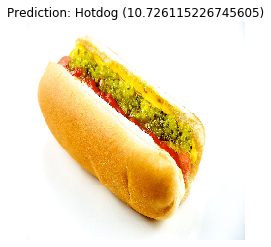

In [6]:
result = model.predict(test_images[0:])
predicted_class = np.argmax(result[0], axis=-1)

plt.imshow(test_images[0])
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: {} ({})".format(predicted_class_name.title(),result[0,predicted_class]))

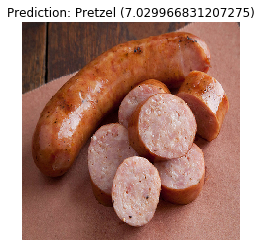

In [7]:
result = model.predict(test_images[1:])
predicted_class = np.argmax(result[0], axis=-1)

plt.imshow(test_images[1])
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: {} ({})".format(predicted_class_name.title(),result[0,predicted_class]))

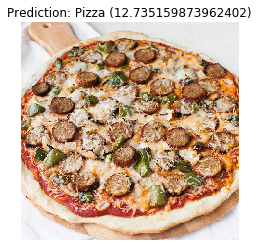

In [8]:
result = model.predict(test_images[2:])
predicted_class = np.argmax(result[0], axis=-1)

plt.imshow(test_images[2])
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: {} ({})".format(predicted_class_name.title(),result[0,predicted_class]))

In [9]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

model.save(export_path, overwrite=True, include_optimizer=False, save_format='tf')

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
total 1372
drwxr-xr-x 1 root root       0 Nov 11 08:17 assets
-rw-r--r-- 1 root root 1401896 Nov 11 08:17 saved_model.pb
drwxr-xr-x 1 root root      88 Nov 11 08:17 variables


In [10]:
new_model = tf.keras.models.load_model(export_path)

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              1280      
Total params: 1,280
Trainable params: 0
Non-trainable params: 1,280
_________________________________________________________________


In [11]:
result = new_model.predict(test_images[0:])
predicted_class = np.argmax(result[0], axis=-1)
print(imagenet_labels[predicted_class])

hotdog


In [12]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['keras_layer_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_keras_layer_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['keras_layer'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1001)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [13]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [14]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=hotdog \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [37]:
!tail server.log

2019-11-11 08:23:59.035963: I tensorflow_serving/core/loader_harness.cc:138] Quiescing servable version {name: hotdog version: 2}
2019-11-11 08:23:59.035983: I tensorflow_serving/core/loader_harness.cc:145] Done quiescing servable version {name: hotdog version: 2}
2019-11-11 08:23:59.035995: I tensorflow_serving/core/loader_harness.cc:120] Unloading servable version {name: hotdog version: 2}
2019-11-11 08:23:59.080939: I ./tensorflow_serving/core/simple_loader.h:363] Calling MallocExtension_ReleaseToSystem() after servable unload with 18874328
2019-11-11 08:23:59.080992: I tensorflow_serving/core/loader_harness.cc:128] Done unloading servable version {name: hotdog version: 2}
2019-11-11 08:24:05.174947: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: hotdog version: 2}
2019-11-11 08:24:05.174988: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: hotdog version: 2}
2019-11-11 08:24:05.175007

In [16]:
data = json.dumps({"signature_name": "serving_default", "instances": test_images.tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 0980393, 0.9607843137254902, 0.9764705882352941]]]]}


In [17]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/hotdog:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

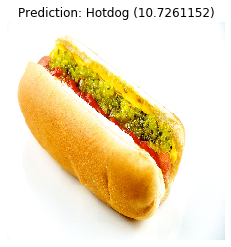

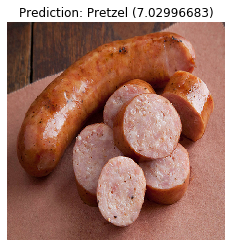

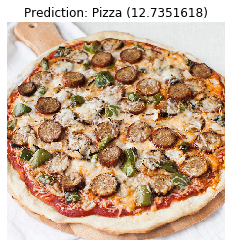

In [18]:
for idx, pred in enumerate(predictions):
    plt.figure()
    plt.imshow(test_images[idx])
    plt.axis('off')
    predicted_class = np.argmax(pred, axis=-1)
    predicted_class_name = imagenet_labels[predicted_class]
    _ = plt.title("Prediction: {} ({})".format(predicted_class_name.title(),pred[predicted_class]))

In [19]:
class PostProcess(layers.Layer):
    def __init__(self, labels, **kwargs):
        super(PostProcess, self).__init__(**kwargs)
        self.labels = labels
    
    def call(self, inputs):
        idx = tf.math.argmax(input=inputs, axis=1)
        res = tf.gather(tf.constant(self.labels), idx)
        res = tf.where(tf.math.equal(res, 'hotdog'), tf.constant('hotdog'), tf.constant('not hotdog'))
        return res
    
    def get_config(self):
        config = super(PostProcess, self).get_config()
        config.update({'labels': self.labels})
        return config

In [31]:
postlayer = PostProcess(imagenet_labels)

In [32]:
model_with_postprocess = tf.keras.Sequential([
    hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,)),
    postlayer
])

In [34]:
MODEL_DIR = tempfile.gettempdir()
version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

model_with_postprocess.save(export_path, overwrite=True, include_optimizer=False, save_format='tf')

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/2


Already saved a model, cleaning up

INFO:tensorflow:Assets written to: /tmp/2/assets


INFO:tensorflow:Assets written to: /tmp/2/assets



Saved model:
total 1484
drwxr-xr-x 1 root root       0 Nov 11 08:24 assets
-rw-r--r-- 1 root root 1519300 Nov 11 08:24 saved_model.pb
drwxr-xr-x 1 root root      88 Nov 11 08:24 variables


In [38]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/hotdog:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

In [39]:
predictions

['hotdog', 'not hotdog', 'not hotdog']

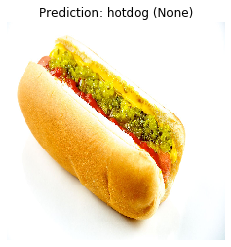

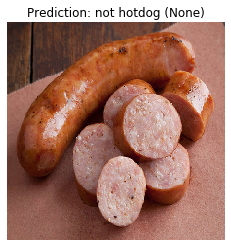

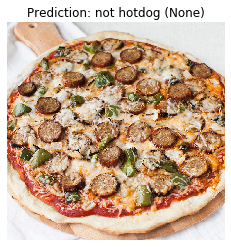

In [40]:
for idx, pred in enumerate(predictions):
    plt.figure()
    plt.imshow(test_images[idx])
    plt.axis('off')
    _ = plt.title("Prediction: {} ({})".format(pred,None))